# Group 3: Influential Superspreader Detection

In [1]:
# --- 1. Imports and Settings ---
import pandas as pd
import numpy as np
import networkx as nx
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score
import seaborn as sns
from itertools import product

# Settings
DATA_PATH = './COVID19.csv'  # adjust if needed
NEWSGUARD_THRESHOLD = 39  # low-credibility threshold

# Parameter grids to test
DELTA_VALUES = [1, 2, 3, 5, 7, 10]  # time slot lengths in days
ALPHA_VALUES = [0.1, 0.3, 0.5, 0.7, 0.9]  # EMA smoothing factors

In [2]:
# --- 2. Load and Preprocess Data ---
df = pd.read_csv(DATA_PATH, parse_dates=['created_at'])

# Filter for low-credibility content
df = df[df['credibility_score'] <= NEWSGUARD_THRESHOLD]
# Remove self-reposts
df = df[df['user_id'] != df['retweeted_user_id']]

print(f"Dataset shape after filtering: {df.shape}")
print(f"Date range: {df['created_at'].min()} to {df['created_at'].max()}")

Dataset shape after filtering: (66504, 6)
Date range: 2020-12-01 00:06:01+00:00 to 2021-03-31 23:56:47+00:00


In [3]:
# --- 3. Helper Functions ---
def compute_influential_by_slot(df, start_date, end_date, delta):
    """
    Partition the data into time slots of length `delta` days and compute
    total re-posts per user in each slot.
    """
    slots = {}
    current_start = start_date
    slot_idx = 0
    while current_start < end_date:
        current_end = current_start + timedelta(days=delta)
        mask = (df['created_at'] >= current_start) & (df['created_at'] < current_end)
        sub = df[mask]
        counts = sub.groupby('retweeted_user_id').size()
        slots[slot_idx] = counts
        slot_idx += 1
        current_start = current_end
    return slots

def ema_scores(slots, alpha):
    times = sorted(slots.keys())
    if not times:
        return pd.Series(dtype=float)
    
    # initialize the EMA with the first time slot
    ema = slots[times[0]].astype(float)

    # iterate through the remaining time slots
    for t in times[1:]:
        # reindex to ensure alignment and fill missing values with 0
        curr = slots[t].reindex(ema.index.union(slots[t].index), fill_value=0)
        # calculate the EMA for the current time slot
        ema = alpha * ema.reindex(curr.index, fill_value=0) + (1 - alpha) * curr
        
    return ema

def network_dismantling(G, ranking, ks):
    """Calculate the percentage of prevented re-posts when removing the top K users"""
    total_weight = sum(d['weight'] for _, _, d in G.edges(data=True))
    if total_weight == 0:
        return {k: 0 for k in ks}
    
    qualities = {}
    for K in ks:
        removed = set(ranking.index[:K])
        prevented = sum(
            data['weight'] for u, v, data in G.edges(data=True)
            if u in removed or v in removed
        )
        qualities[K] = prevented / total_weight
    return qualities

def compute_ndcg(pred_ranking, truth_ranking, K):
    """Compute nDCG@K"""
    # Get the top K users from truth_ranking
    users = list(truth_ranking.index[:K])
    if not users:
        return 0.0

    # get the scores for these users in both rankings
    y_true = np.array([truth_ranking.get(u, 0) for u in users], dtype=float)
    y_score = np.array([pred_ranking.get(u, 0) for u in users], dtype=float)
    
    # Replace any NaNs
    y_true = np.nan_to_num(y_true)
    y_score = np.nan_to_num(y_score)
    
    # Check if all values are zero
    if np.sum(y_true) == 0 or np.sum(y_score) == 0:
        return 0.0
    
    return ndcg_score(y_true.reshape(1, -1), y_score.reshape(1, -1), k=K)

In [4]:
# --- 4. Build Network (once) ---
G = nx.DiGraph()
for _, row in df.iterrows():
    u, v = row['retweeted_user_id'], row['user_id']
    G.add_edge(u, v, weight=G[u][v]['weight'] + 1 if G.has_edge(u, v) else 1)

# Compute ground truth for comparison
ground_truth = df.groupby('retweeted_user_id').size().sort_values(ascending=False)
print(f"Network nodes: {G.number_of_nodes()}, edges: {G.number_of_edges()}")

Network nodes: 9137, edges: 19278


In [5]:
# --- 5. Parameter Testing ---
min_date, max_date = df['created_at'].min(), df['created_at'].max()
Ks = [5, 10, 20, 50]

# Store results
results_list = []

print("Testing parameter combinations...")
total_combinations = len(DELTA_VALUES) * len(ALPHA_VALUES)
current_combination = 0

for delta, alpha in product(DELTA_VALUES, ALPHA_VALUES):
    current_combination += 1
    print(f"Testing delta={delta}, alpha={alpha} ({current_combination}/{total_combinations})")
    
    try:
        # Compute influential scores for this parameter combination
        slots = compute_influential_by_slot(df, min_date, max_date, delta)
        
        if not slots or all(len(slot) == 0 for slot in slots.values()):
            print(f"  No data for delta={delta}, alpha={alpha}")
            continue
            
        influential_ema = ema_scores(slots, alpha)
        
        if len(influential_ema) == 0:
            print(f"  Empty EMA results for delta={delta}, alpha={alpha}")
            continue
            
        predicted_ranking = influential_ema.sort_values(ascending=False)
        
        # Evaluate performance
        quality_pred = network_dismantling(G, predicted_ranking, Ks)
        quality_truth = network_dismantling(G, ground_truth, Ks)
        
        # Compute nDCG for each K
        ndcg_scores = {K: compute_ndcg(predicted_ranking, ground_truth, K) for K in Ks}
        
        # Store results for each K
        for K in Ks:
            results_list.append({
                'delta': delta,
                'alpha': alpha,
                'K': K,
                'quality_pred': quality_pred[K],
                'quality_truth': quality_truth[K],
                'ndcg': ndcg_scores[K],
                'relative_quality': quality_pred[K] / quality_truth[K] if quality_truth[K] > 0 else 0
            })
            
        print(f"  ✓ Completed delta={delta}, alpha={alpha}")
        
    except Exception as e:
        print(f"  ✗ Error with delta={delta}, alpha={alpha}: {str(e)}")
        continue

# Convert to DataFrame
results_df = pd.DataFrame(results_list)
print(f"\nCompleted testing. Results shape: {results_df.shape}")

Testing parameter combinations...
Testing delta=1, alpha=0.1 (1/30)
  ✓ Completed delta=1, alpha=0.1
Testing delta=1, alpha=0.3 (2/30)
  ✓ Completed delta=1, alpha=0.3
Testing delta=1, alpha=0.5 (3/30)
  ✓ Completed delta=1, alpha=0.5
Testing delta=1, alpha=0.7 (4/30)
  ✓ Completed delta=1, alpha=0.7
Testing delta=1, alpha=0.9 (5/30)
  ✓ Completed delta=1, alpha=0.9
Testing delta=2, alpha=0.1 (6/30)
  ✓ Completed delta=2, alpha=0.1
Testing delta=2, alpha=0.3 (7/30)
  ✓ Completed delta=2, alpha=0.3
Testing delta=2, alpha=0.5 (8/30)
  ✓ Completed delta=2, alpha=0.5
Testing delta=2, alpha=0.7 (9/30)
  ✓ Completed delta=2, alpha=0.7
Testing delta=2, alpha=0.9 (10/30)
  ✓ Completed delta=2, alpha=0.9
Testing delta=3, alpha=0.1 (11/30)
  ✓ Completed delta=3, alpha=0.1
Testing delta=3, alpha=0.3 (12/30)
  ✓ Completed delta=3, alpha=0.3
Testing delta=3, alpha=0.5 (13/30)
  ✓ Completed delta=3, alpha=0.5
Testing delta=3, alpha=0.7 (14/30)
  ✓ Completed delta=3, alpha=0.7
Testing delta=3, alpha=


=== BEST PARAMETERS BY METRIC ===

K = 5:
  Best nDCG@5: 1.0000 (delta=7.0, alpha=0.5)
  Best Quality@5: 0.6099 (delta=5.0, alpha=0.9)
  Best Relative Quality@5: 0.9995 (delta=5.0, alpha=0.9)

K = 10:
  Best nDCG@10: 1.0000 (delta=10.0, alpha=0.9)
  Best Quality@10: 0.7054 (delta=5.0, alpha=0.9)
  Best Relative Quality@10: 0.9961 (delta=5.0, alpha=0.9)

K = 20:
  Best nDCG@20: 0.9991 (delta=7.0, alpha=0.9)
  Best Quality@20: 0.7637 (delta=7.0, alpha=0.9)
  Best Relative Quality@20: 0.9897 (delta=7.0, alpha=0.9)

K = 50:
  Best nDCG@50: 0.9982 (delta=7.0, alpha=0.9)
  Best Quality@50: 0.8639 (delta=7.0, alpha=0.9)
  Best Relative Quality@50: 0.9958 (delta=7.0, alpha=0.9)


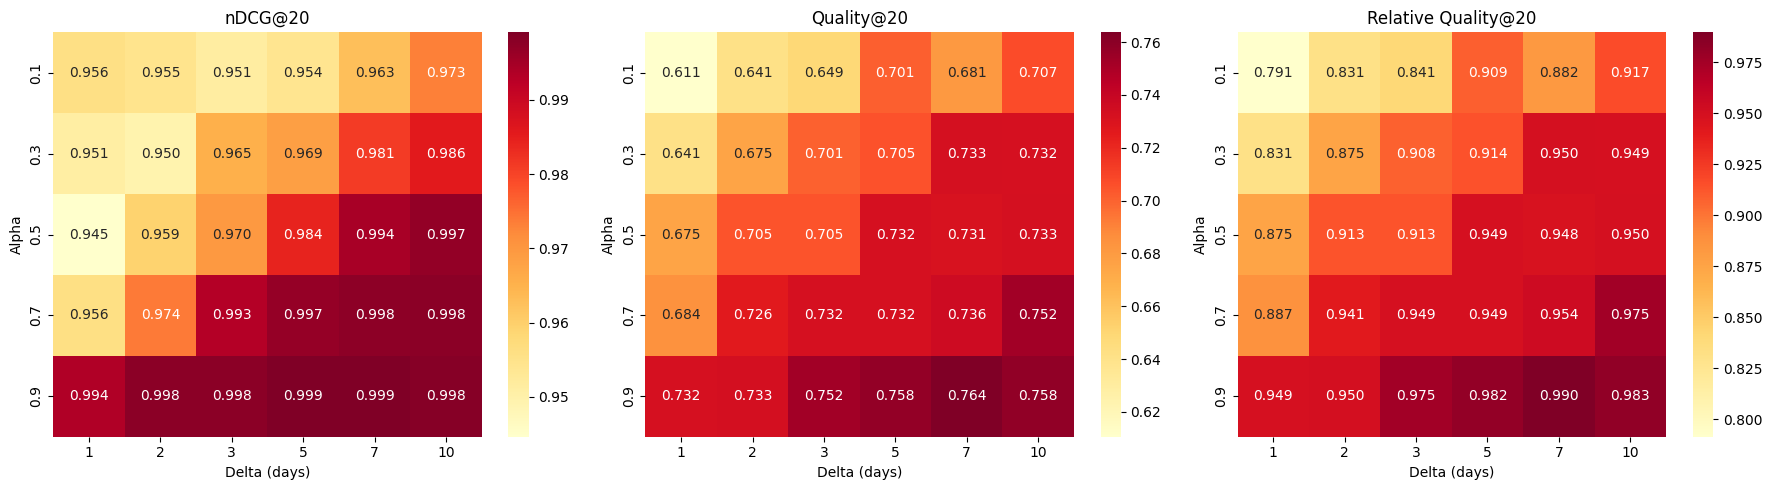

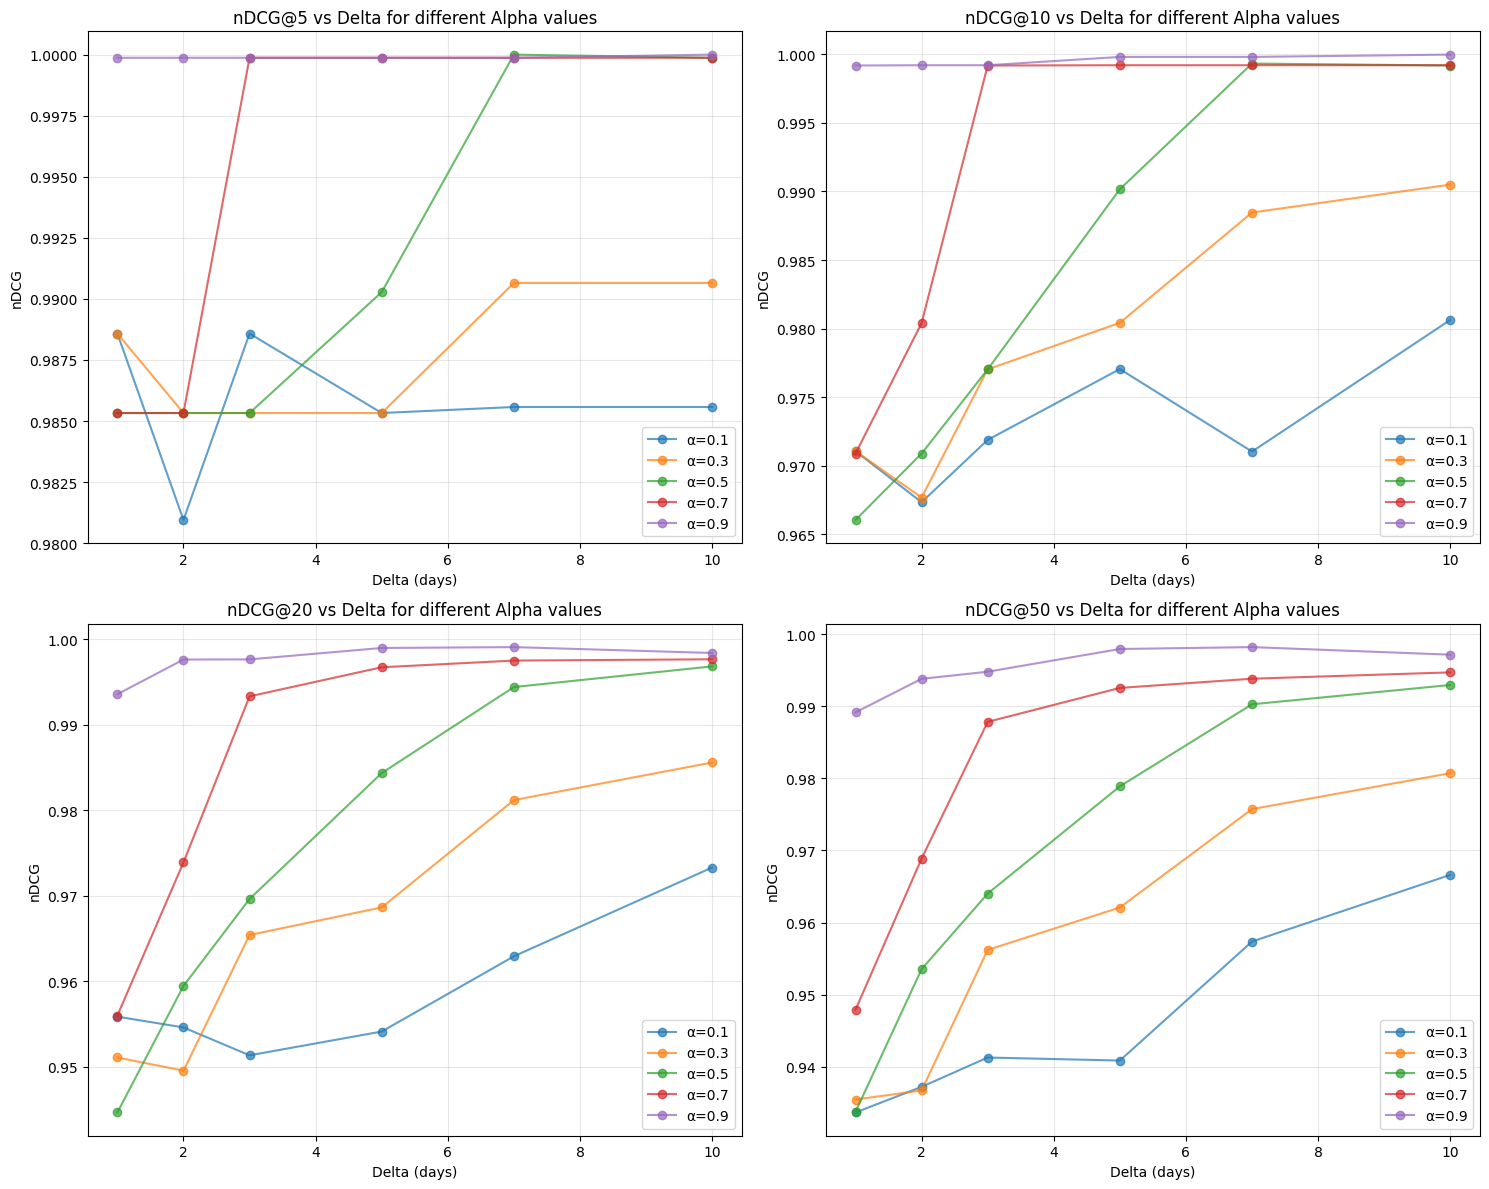


=== SUMMARY STATISTICS ===

Top 10 parameter combinations by average nDCG:
delta  alpha
7      0.9      0.999249
5      0.9      0.999157
10     0.9      0.998889
3      0.9      0.997884
10     0.7      0.997865
2      0.9      0.997633
7      0.7      0.997607
10     0.5      0.997214
5      0.7      0.997091
7      0.5      0.996007
Name: ndcg, dtype: float64

Top 10 parameter combinations by average Quality:
delta  alpha
7      0.9      0.735753
10     0.9      0.734008
5      0.9      0.733471
3      0.9      0.720468
10     0.7      0.718803
7      0.7      0.712950
2      0.9      0.712145
10     0.5      0.708687
5      0.7      0.705168
1      0.9      0.699048
Name: quality_pred, dtype: float64

Results saved to 'parameter_test_results.csv'


In [ ]:
# --- 6. Analysis and Visualization ---
if len(results_df) > 0:
    # Display best parameters for each metric and K
    print("\n=== BEST PARAMETERS BY METRIC ===")
    
    for K in Ks:
        subset = results_df[results_df['K'] == K]
        if len(subset) == 0:
            continue
            
        print(f"\nK = {K}:")
        
        # Best nDCG
        best_ndcg = subset.loc[subset['ndcg'].idxmax()]
        print(f"  Best nDCG@{K}: {best_ndcg['ndcg']:.4f} (delta={best_ndcg['delta']}, alpha={best_ndcg['alpha']})")
        
        # Best Quality
        best_quality = subset.loc[subset['quality_pred'].idxmax()]
        print(f"  Best Quality@{K}: {best_quality['quality_pred']:.4f} (delta={best_quality['delta']}, alpha={best_quality['alpha']})")
        
        # Best Relative Quality
        best_relative = subset.loc[subset['relative_quality'].idxmax()]
        print(f"  Best Relative Quality@{K}: {best_relative['relative_quality']:.4f} (delta={best_relative['delta']}, alpha={best_relative['alpha']})")

    # --- 7. Heatmaps for K=20 (as example) ---
    k_example = 20
    subset_k = results_df[results_df['K'] == k_example]
    
    if len(subset_k) > 0:
        # Create pivot tables for heatmaps
        ndcg_pivot = subset_k.pivot(index='alpha', columns='delta', values='ndcg')
        quality_pivot = subset_k.pivot(index='alpha', columns='delta', values='quality_pred')
        relative_pivot = subset_k.pivot(index='alpha', columns='delta', values='relative_quality')
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # nDCG Heatmap
        sns.heatmap(ndcg_pivot, annot=True, fmt='.3f', cmap='YlOrRd', ax=axes[0])
        axes[0].set_title(f'nDCG@{k_example}')
        axes[0].set_xlabel('Delta (days)')
        axes[0].set_ylabel('Alpha')
        
        # Quality Heatmap
        sns.heatmap(quality_pivot, annot=True, fmt='.3f', cmap='YlOrRd', ax=axes[1])
        axes[1].set_title(f'Quality@{k_example}')
        axes[1].set_xlabel('Delta (days)')
        axes[1].set_ylabel('Alpha')
        
        # Relative Quality Heatmap
        sns.heatmap(relative_pivot, annot=True, fmt='.3f', cmap='YlOrRd', ax=axes[2])
        axes[2].set_title(f'Relative Quality@{k_example}')
        axes[2].set_xlabel('Delta (days)')
        axes[2].set_ylabel('Alpha')
        
        plt.tight_layout()
        plt.show()
        
    # --- 8. Line plots showing parameter effects ---
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    for i, K in enumerate([5, 10, 20, 50]):
        row, col = i // 2, i % 2
        subset = results_df[results_df['K'] == K]
        
        if len(subset) == 0:
            continue
        
        # Group by parameters and compute mean metrics
        grouped = subset.groupby(['delta', 'alpha']).agg({
            'ndcg': 'mean',
            'quality_pred': 'mean',
            'relative_quality': 'mean'
        }).reset_index()
        
        # Plot for different alpha values
        for alpha in ALPHA_VALUES:
            alpha_data = grouped[grouped['alpha'] == alpha]
            if len(alpha_data) > 0:
                axes[row, col].plot(alpha_data['delta'], alpha_data['ndcg'], 
                                  marker='o', label=f'α={alpha}', alpha=0.7)
        
        axes[row, col].set_title(f'nDCG@{K} vs Delta for different Alpha values')
        axes[row, col].set_xlabel('Delta (days)')
        axes[row, col].set_ylabel('nDCG')
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # --- 9. Summary Statistics ---
    print("\n=== SUMMARY STATISTICS ===")
    summary_stats = results_df.groupby(['delta', 'alpha']).agg({
        'ndcg': ['mean', 'std'],
        'quality_pred': ['mean', 'std'],
        'relative_quality': ['mean', 'std']
    }).round(4)
    
    print("\nTop 10 parameter combinations by average nDCG:")
    avg_ndcg = results_df.groupby(['delta', 'alpha'])['ndcg'].mean().sort_values(ascending=False)
    print(avg_ndcg.head(10))
    
    print("\nTop 10 parameter combinations by average Quality:")
    avg_quality = results_df.groupby(['delta', 'alpha'])['quality_pred'].mean().sort_values(ascending=False)
    print(avg_quality.head(10))
    
else:
    print("No results to display - check data and parameters!")
